In [74]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult, BAD_RXNS, FREE_RXNS

sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [75]:
time = '10'
date = '2023-04-24'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [76]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [77]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [78]:
kind = 'ecoli-metabolism-redux'

if kind == 'ecoli-metabolism-redux':
    metabolism = agent['ecoli-metabolism-redux']
    stoichiometry = metabolism.stoichiometry
    stoichiometric_matrix_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}
elif kind == 'ecoli-metabolism':
    stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
    maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
    stoichiometry["maintenance_reaction"] = maintenance_reaction


# for rxn in BAD_RXNS:
#     stoichiometric_matrix_dict.pop(rxn, None)

Pandas automatically understands dicts of dicts as matrices.

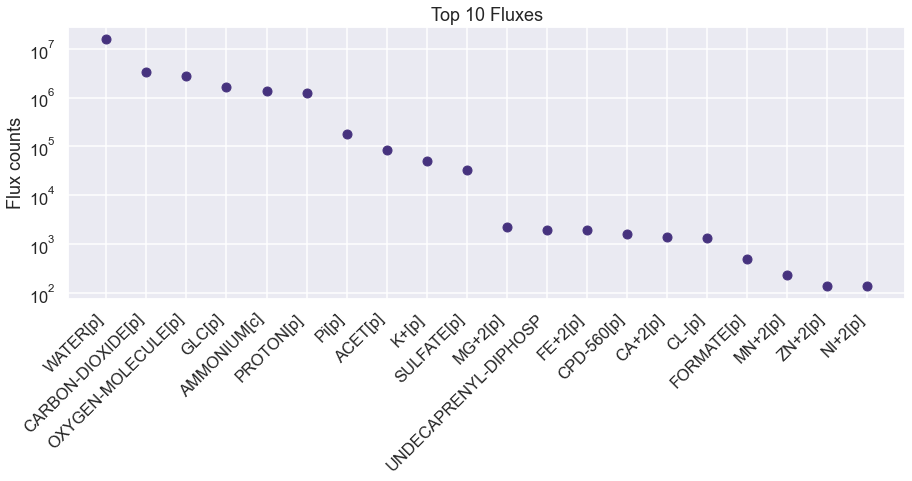

In [79]:
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[4, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

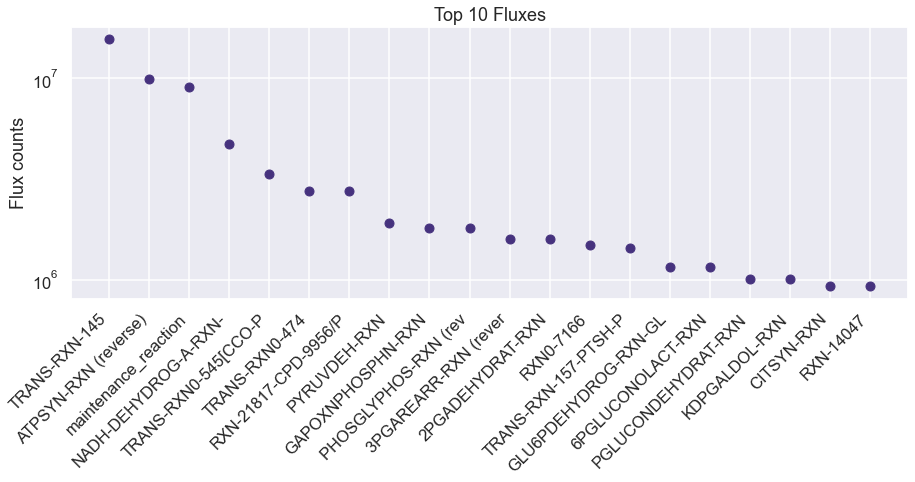

In [80]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))


# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
# log scale
plt.yscale('log')
plt.title('Top 10 Fluxes')
plt.show()

In [81]:
sim_fluxes.head(20)

,4
TRANS-RXN-145,15675360.0
ATPSYN-RXN (reverse),9936179.0
maintenance_reaction,9067240.0
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,4744591.0
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),3364670.0
TRANS-RXN0-474,2771827.0
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.,2771749.0
PYRUVDEH-RXN,1910777.0
GAPOXNPHOSPHN-RXN,1813836.0
PHOSGLYPHOS-RXN (reverse),1813828.0


In [82]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"])
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
RXN0-1741-MALTOSE//MALTOSE.17.,40249
RXN-15315,40223
TRANS-RXN0-445-CHITOBIOSE//CHITOBIOSE.23.,40223
RXN0-0-N-ACETYLNEURAMINATE//N-ACETYLNEURAMINATE.41.,40223
RXN0-0-N-ACETYLNEURAMINATE//CPD0-1123.31.,40223
...,...
TRANS-RXN-100,0
RXN-17726-CPD-3561/WATER//GALACTOSE/CPD-10723.36.,0
RXN-17726-CPD-3561/WATER//GALACTOSE/BETA-D-FRUCTOSE.42.,0
RXN-17726,0


# Test changing nutrient composition

In [83]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        # "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  # "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [84]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["maintenance_target"]).at[4, 'maintenance_reaction']
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]     73.0
2-KETOGLUTARATE[c]          186.0
2-PG[c]                      49.0
2K-4CH3-PENTANOATE[c]        73.0
4-AMINO-BUTYRATE[c]         160.0
                            ...  
MN+2[p]                      52.0
NA+[p]                       52.0
OXYGEN-MOLECULE[p]           51.0
CA+2[p]                      52.0
Pi[p]                        52.0
Name: 4, Length: 171, dtype: float64

In [85]:
model = NetworkFlowModel(reactions=stoichiometric_matrix_dict,
                         homeostatic_metabolites=metabolism.homeostatic_objective,
                         free_reactions=FREE_RXNS)

In [86]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [87]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                   objective_weights={'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

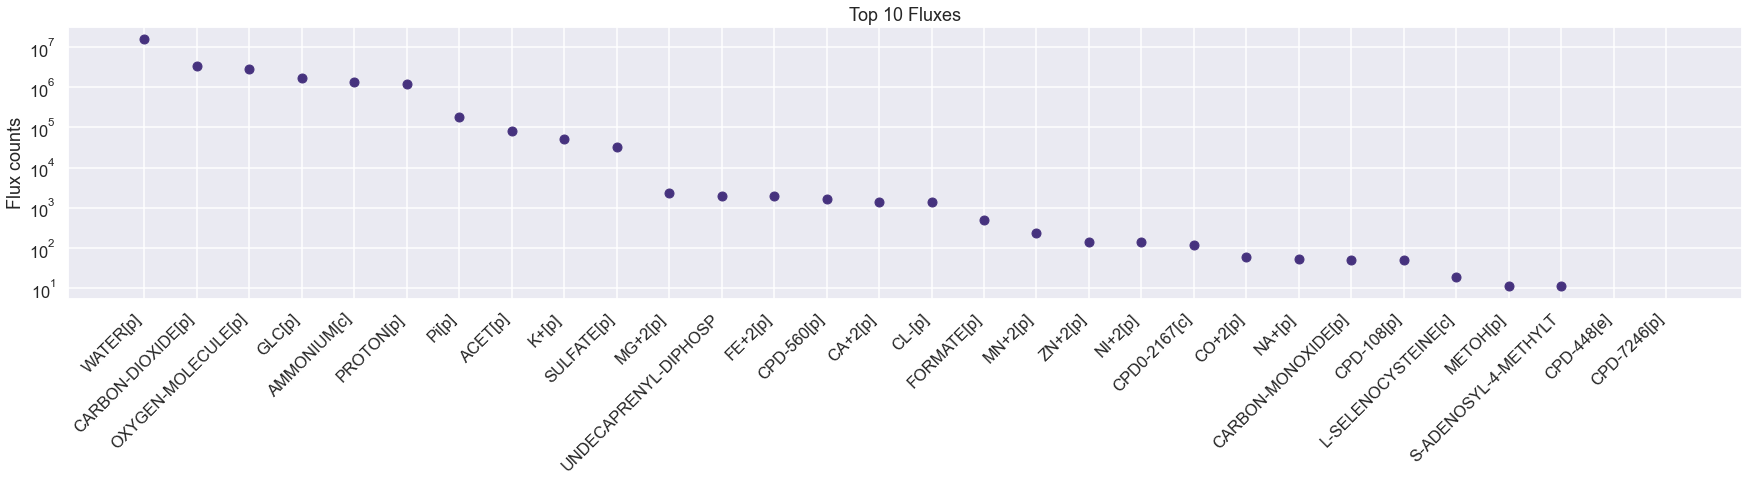

In [88]:
cur_exchanges = pd.Series(solution.exchanges).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(30), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(30)], [i[:20] for i in cur_exchanges.index[:30]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

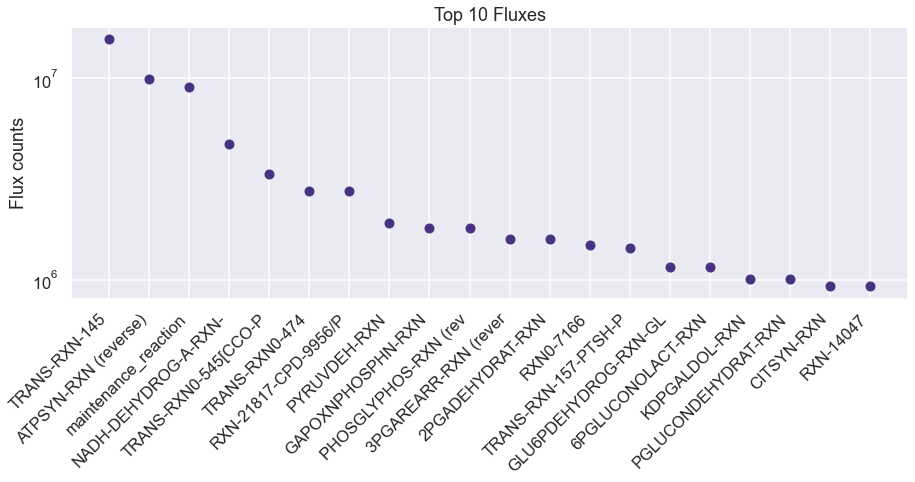

In [89]:
cur_fluxes = pd.Series(solution.velocities).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

## Connect to EcoCyc to go from Genes -> Reactions

In [90]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [91]:
{"G6245", "G7431", "G7452"}

{'G6245', 'G7431', 'G7452'}

In [92]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": {"EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"},
                      "Add": {"FUM[p]", 'HYDROGEN-MOLECULE[p]'},
                      "Remove": {"GLC[p]", "OXYGEN-MOLECULE[p]"},
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": {"EG10814", "EG10815", "EG10816", "EG10818"},
                      "Add": {"D-Ribopyranose[p]"},
                      "Remove": {"GLC[p]"},
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": {"EG11574", "G6566", "M007", "EG11573", "EG11572"},
                      "Add": {"THIAMINE[p]"},
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": {"EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"},
                      "Add": {"NITRATE[p]"},
                      "Remove": {"OXYGEN-MOLECULE[p]"},
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": {"M010", "M011", "M012", "G6206"},
                      "Add": {"3-PHENYLPROPIONATE[p]"},
                      "Remove": {"GLC[p]"},
                      },

                  5: {"Environment": "Molybdenum cofactor synthesis",
                      "Genes": {"EG11595", "EG11666", "EG11597", "EG11598", "EG11829", "G7496", "EG10002", "EG10152",
                                "EG10153", "EG10154"},
                      "Add": {"CPD-3[p]"},
                      "Remove": set(),
                      "Demand": {"CPD-8123[c]"},
                      },

                  6: {"Environment": "pre-Quenosine synthesis",
                      "Genes": {"G6245", "G7431", "G7452"},
                      "Add": set(),
                      "Remove": set(),
                      "Demand": {"7-AMINOMETHYL-7-DEAZAGUANINE[c]"},
                      },


                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df["Demand"] = condition_df["Demand"].fillna(False)
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11799, G7554, EG10468, EG10470, EG11801, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",False,[nan]
1,Ribose C-source,"{EG10814, EG10818, EG10815, EG10816}",{D-Ribopyranose[p]},{GLC[p]},False,[nan]
2,Thiamine salvaging,"{EG11572, EG11574, G6566, M007, EG11573}",{THIAMINE[p]},{},False,[nan]
3,Nitrate as reduction target,"{EG10640, EG10638, EG10639, EG10647, EG10648, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,[nan]
4,3-Phenylpropionate as carbon and energy source,"{M011, G6206, M010, M012}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,[nan]
5,Molybdenum cofactor synthesis,"{EG11598, EG11666, EG10152, EG11597, EG11595, ...",{CPD-3[p]},{},{CPD-8123[c]},[nan]
6,pre-Quenosine synthesis,"{G6245, G7452, G7431}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},[nan]


In [93]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [94]:
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{EG11799, G7554, EG10468, EG10470, EG11801, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",False,"{RXN0-7399, RXN0-5256, RXN-16420}"
1,Ribose C-source,"{EG10814, EG10818, EG10815, EG10816}",{D-Ribopyranose[p]},{GLC[p]},False,"{ABC-28-RXN, RIBOKIN-RXN}"
2,Thiamine salvaging,"{EG11572, EG11574, G6566, M007, EG11573}",{THIAMINE[p]},{},False,"{THIKIN-RXN, RXN0-7298, ABC-32-RXN, THIAZOLSYN..."
3,Nitrate as reduction target,"{EG10640, EG10638, EG10639, EG10647, EG10648, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,"{RXN-15119, RXN0-3501, RXN0-7124}"
4,3-Phenylpropionate as carbon and energy source,"{M011, G6206, M010, M012}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,"{TRANS-RXN0-457, 1.13.11.16-RXN, TRANS-RXN-61,..."
5,Molybdenum cofactor synthesis,"{EG11598, EG11666, EG10152, EG11597, EG11595, ...",{CPD-3[p]},{},{CPD-8123[c]},"{RXN-8342, RXN0-262, RXN0-6254, RXN-8340, RXN-..."
6,pre-Quenosine synthesis,"{G6245, G7452, G7431}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},"{RXN-12093, RXN0-5507, RXN0-4022}"


## Quick and dirty loop (after init)

In [95]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = (fba["unconstrained_molecules"][3]).copy()
    uptake_c = fba["constrained_molecules"]

    homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :])
    new_demand = condition_df.at[condition_idx, "Demand"]
    if new_demand:
        for met in new_demand:
            homeostatic[met] = 100

    uptake.extend(list(uptake_c.keys()))
    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    model = NetworkFlowModel(reactions=stoichiometric_matrix_dict,
                         homeostatic_metabolites=homeostatic,
                         free_reactions=FREE_RXNS)

    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)

    solution: FlowResult = model.solve(homeostatic_targets=homeostatic,
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                   objective_weights={'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]], stoichiometric_matrix_dict[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux", "Stoichiometry"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx, :]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

    print(f"""finished {condition_df.at[condition_idx, "Environment"]}""")

finished Hydrogen + fumarate, -O2, -Glc
finished Ribose C-source
finished Thiamine salvaging
finished Nitrate as reduction target
finished 3-Phenylpropionate as carbon and energy source
finished Molybdenum cofactor synthesis
finished pre-Quenosine synthesis


In [108]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df["log(Flux)"] = np.log10(results_df["Flux"])
results_df

,Environment,Reaction,Flux,log(Flux)
0,"Hydrogen + fumarate, -O2, -Glc",RXN0-5256-CPD-9728/P,2.367649e+07,7.374317
0,Ribose C-source,ABC-28-RXN-ATP/D-Rib,2.029540e+06,6.307398
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,1.264890e+06,6.102053
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,7.646495e+05,5.883462
0,Thiamine salvaging,THIKIN-RXN,4.900000e+01,1.690196
0,Thiamine salvaging,ABC-32-RXN,4.900000e+01,1.690196
0,Nitrate as reduction target,RXN0-3501-NITRATE/RE,1.405236e+06,6.147749
0,Nitrate as reduction target,RXN0-7124-NITRATE/CP,2.350110e+05,5.371088
0,3-Phenylpropionate as carbon and energy source,1.13.11.16-RXN,1.284798e+06,6.108835
0,3-Phenylpropionate as carbon and energy source,MHPCHYDROL-RXN,1.284798e+06,6.108835


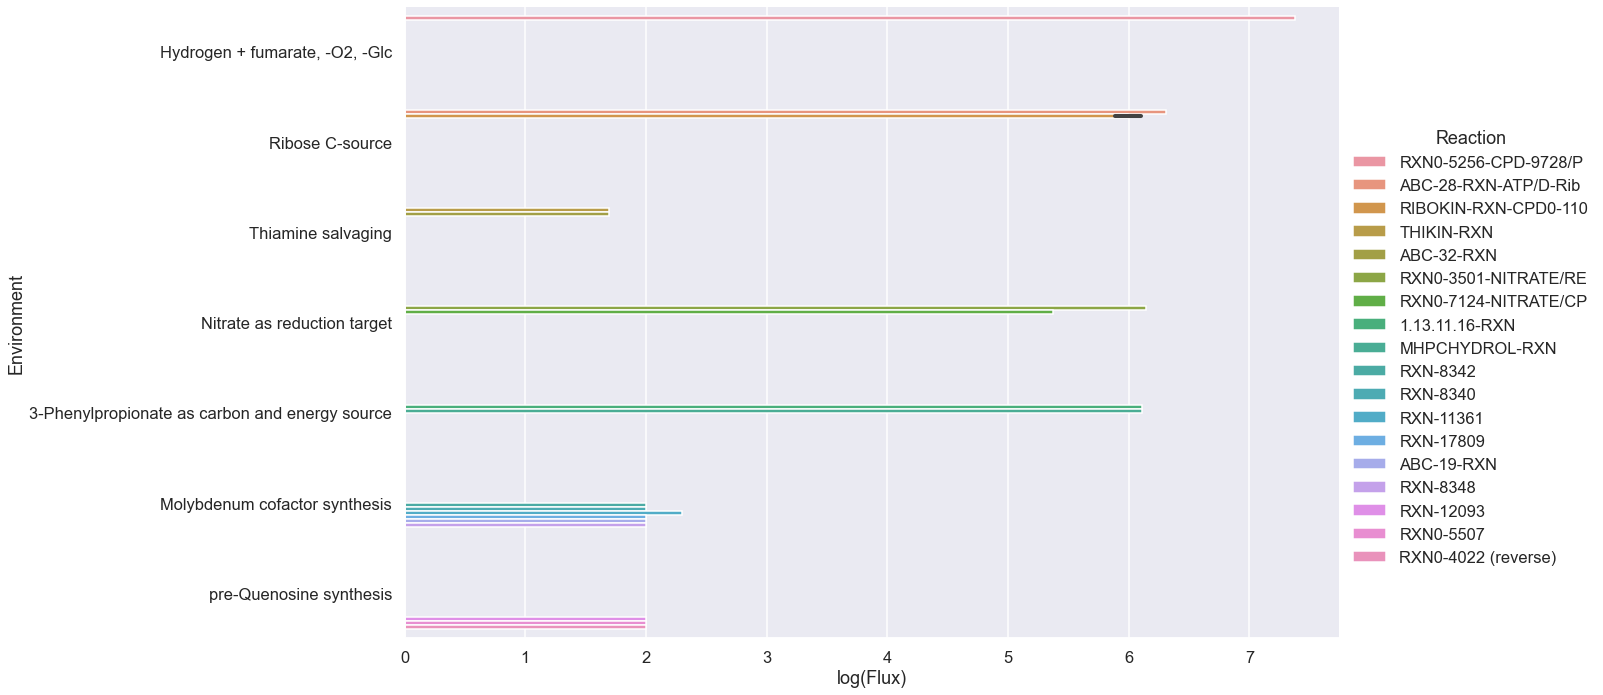

In [114]:
# for each environment, plot the fluxes of the reactions that are relevant to that environment
g = sns.catplot(y="Environment",hue="Reaction", x="log(Flux)", data=results_df, kind="bar", aspect=2, height=10, sharey=False)
g.savefig("notebooks/fbagd/figures/rxns_light_up.pdf")

# Check kinetics

In [71]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :])
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["maintenance_target"]).at[4, 'maintenance_reaction']
kinetic = dict(pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :])
sim_fluxes = dict(pd.DataFrame(fba["estimated_fluxes"]).loc[4, :])

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

In [63]:
model = NetworkFlowModel(reactions=stoichiometric_matrix_dict,
                         homeostatic_metabolites=metabolism.homeostatic_objective,
                         free_reactions=FREE_RXNS)

model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

solution: FlowResult = model.solve(homeostatic_targets=homeostatic,
                                   maintenance_target=maintenance,
                                   kinetic_targets=kinetic,
                                   reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                   objective_weights={'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.00001},
                                   upper_flux_bound=100000000)

In [64]:
solution.velocities

{'1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN': -0.0,
 '1.1.1.127-RXN': -0.0,
 '1.1.1.127-RXN (reverse)': -0.0,
 '1.1.1.215-RXN (reverse)': -0.0,
 '1.1.1.251-RXN': -0.0,
 '1.1.1.251-RXN (reverse)': -0.0,
 '1.1.1.271-RXN (reverse)': -0.0,
 '1.1.1.274-RXN (reverse)': -0.0,
 '1.1.1.283-RXN (reverse)': -0.0,
 '1.1.1.39-RXN': -0.0,
 '1.1.1.83-RXN': -0.0,
 '1.11.1.15-RXN': -0.0,
 '1.13.11.16-RXN': 0.0,
 '1.3.1.9-RXN (reverse)': -0.0,
 '1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44.': -0.0,
 '1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse)': 15408.0,
 '1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36.': -0.0,
 '1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36. (reverse)': 3621.999999999991,
 '1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.': -0.0,
 '1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.': 0.0,
 '1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytoch

In [65]:
comparison = {key: [kinetic[key], solution.velocities[key]] for key in kinetic.keys()}
comparison = pd.DataFrame(comparison).T.reset_index()
comparison.columns = ["Reaction", "Target", "Estimated"]
# comparison = comparison.melt(id_vars="Reaction", value_vars=["Target", "Estimated"], var_name="Type", value_name="Flux")
comparison

,Reaction,Target,Estimated
0,1.1.1.39-RXN,123358.0,-0.0
1,1.1.1.83-RXN,10129.0,-0.0
2,1.13.11.16-RXN,133.0,0.0
3,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/N...,15408.0,15408.0
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,3129.0,-0.0
...,...,...,...
425,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UN...,574.0,574.0
426,URA-PHOSPH-RXN,7558.0,-0.0
427,UROGENIIISYN-RXN,62030.0,107.0
428,URPHOS-RXN__URPHOS-CPLX,542101.0,-0.0


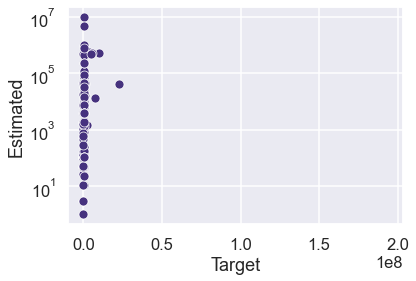

In [66]:
sns.scatterplot(x="Target", y="Estimated", data=comparison)
plt.yscale('log')

## Evaluate actual sim fluxes

In [68]:
fba.keys()

dict_keys(['estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'target_kinetic_fluxes', 'estimated_exchange_dmdt', 'estimated_intermediate_dmdt', 'maintenance_target', 'reaction_catalyst_counts', 'time_per_step', 'unconstrained_molecules', 'constrained_molecules'])

In [73]:
sim_comparison = {key: [kinetic[key], solution.velocities[key]] for key in kinetic.keys()}
sim_comparison = pd.DataFrame(sim_comparison).T.reset_index()
sim_comparison.columns = ["Reaction", "Target", "Estimated"]
# comparison = comparison.melt(id_vars="Reaction", value_vars=["Target", "Estimated"], var_name="Type", value_name="Flux")
sim_comparison

,Reaction,Target,Estimated
0,1.1.1.39-RXN,123358.0,-0.0
1,1.1.1.83-RXN,10129.0,-0.0
2,1.13.11.16-RXN,133.0,0.0
3,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/N...,15408.0,15408.0
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,3129.0,-0.0
...,...,...,...
425,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UN...,574.0,574.0
426,URA-PHOSPH-RXN,7558.0,-0.0
427,UROGENIIISYN-RXN,62030.0,107.0
428,URPHOS-RXN__URPHOS-CPLX,542101.0,-0.0
